In [1]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import numpy as np
from pycuda.compiler import SourceModule

from pycuda.compiler import SourceModule

In [14]:
mod = SourceModule(open("./patchmatch.cu").read())

patchmatch = mod.get_function("multiply_them_2d")

rows,cols,channels = 500,500 , 80

def get_blocks_for_dim(dim,blocks):
    if rows % blocks ==0:
        return rows//blocks
    return rows// blocks +1 

a = numpy.random.randn(rows,cols).astype(numpy.float32)
b = numpy.random.randn(rows,cols).astype(numpy.float32)

threads = 20

dest = numpy.zeros_like(a)
# patchmatch(
#         drv.Out(dest), drv.In(a), drv.In(b),np.int32(rows), np.int32(cols), np.int32(channels),
#         block=(threads,threads,1),
#         grid=(get_blocks_for_dim(rows,threads),
#               get_blocks_for_dim(cols,threads))
# )


# patchmatch(
#         drv.Out(dest), drv.In(a), drv.In(b),np.int32(rows), np.int32(cols), np.int32(channels),
#         block=(threads,threads,1),
#         grid=(get_blocks_for_dim(rows,threads),
#               get_blocks_for_dim(cols,threads))
# )


patchmatch(
        drv.InOut(dest), drv.In(a), drv.In(b),np.int32(rows), np.int32(cols),
        block=(threads,threads,1),
        grid=(get_blocks_for_dim(rows,threads),
              get_blocks_for_dim(cols,threads))
)


# print( numpy.unique(numpy.rollaxis(dest,2,0)[0]))
# print( numpy.unique(numpy.rollaxis(dest,2,0)[1]))
# print( numpy.unique(numpy.rollaxis(dest,2,0)[2]))
# print( dest- 2*a*b)
print(np.unique( dest- 2*a*b))
print(dest)

[ -7.52616119  -4.50762749  -3.68769264 ...,  31.39338303  32.11295319
  34.32965851]
[[ 15.  15.  15. ...,  15.  15.  15.]
 [ 15.  15.  15. ...,  15.  15.  15.]
 [ 15.  15.  15. ...,  15.  15.  15.]
 ..., 
 [ 15.  15.  15. ...,  15.  15.  15.]
 [ 15.  15.  15. ...,  15.  15.  15.]
 [ 15.  15.  15. ...,  15.  15.  15.]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(52): warning: variable "col" was declared but never referenced

kernel.cu(52): warning: variable "col" was declared but never referenced


  # Remove the CWD from sys.path while we load stuff.


In [79]:
"""
The Patchmatch Algorithm. The actual algorithm is a nearly
line to line port of the original c++ version.
The distance calculation is different to leverage numpy's vectorized
operations.

This version uses 4 images instead of 2.
You can supply the same image twice to use patchmatch between 2 images.

"""

import numpy as np
import cv2
import pycuda.autoinit
import pycuda.driver as drv
import numpy
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import numpy as np
from pycuda.compiler import SourceModule
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
import cv2

from PIL import Image

class PatchMatch(object):
    def __init__(self, a, aa, b, bb, patch_size):
        """
        Initialize Patchmatch Object.
        This method also randomizes the nnf , which will eventually
        be optimized.
        """
        assert a.shape == b.shape == aa.shape == bb.shape, "Dimensions were unequal for patch-matching input"
        self.A = a
        self.B = b
        self.AA = aa
        self.BB = bb
        self.patch_size = patch_size
        self.nnf = np.zeros(shape=(2, self.A.shape[0], self.A.shape[1])).astype(np.int32)  # the nearest neighbour field
        self.nnd = np.random.rand(self.A.shape[0], self.A.shape[1]).astype(np.float32) *100  # the distance map for the nnf
        self.initialise_nnf()

    def initialise_nnf(self):
        """
        Set up a random NNF
        Then calculate the distances to fill up the NND
        :return:
        """
        self.nnf[0] = np.random.randint(self.B.shape[1], size=(self.A.shape[0], self.A.shape[1]))*0
        self.nnf[1] = np.random.randint(self.B.shape[0], size=(self.A.shape[0], self.A.shape[1]))*0
        self.nnf = self.nnf.transpose((1, 2, 0)) 
        self.nnf = self.nnf.copy("C")
    
    def visualize(self):
        """
        Get the NNF visualisation
        :return: The RGB Matrix of the NNF
        """
        nnf = self.nnf

        img = np.zeros((nnf.shape[0], nnf.shape[1], 3), dtype=np.uint8)

        for i in range(nnf.shape[0]):
            for j in range(nnf.shape[1]):
                pos = nnf[i, j]
                img[i, j, 0] = int(255 * (pos[0] / self.B.shape[1]))
                img[i, j, 2] = int(255 * (pos[1] / self.B.shape[0]))

        return img
    
# __global__ void patch_match(float *a, 
#                             float *aa,
#                             float *b, 
#                             float *bb,
#                             float *nnf,
#                             float *nnd,
#                             int rows, 
#                             int cols , 
#                             int channels, 
#                             int patch_size, 
#                             int iters,
#                             int jump_size)



    def propagate(self, iters=2, rand_search_radius=200,queue=None):
        """
        Optimize the NNF using PatchMatch Algorithm
        :param iters: number of iterations
        :param rand_search_radius: max radius to use in random search
        :return:
        """
        
        mod = SourceModule(open("./patchmatch.cu").read())
        patchmatch = mod.get_function("patch_match")
        
        rows = self.A.shape[0]
        cols = self.A.shape[1]
        channels = np.int32(self.A.shape[2])
        
        threads = 20
        
        def get_blocks_for_dim(dim,blocks):
            if dim % blocks ==0:
                return dim//blocks
            return dim// blocks +1 

        print(self.nnf)


        patchmatch(
            drv.In(self.A),
            drv.In(self.AA),
            drv.In(self.B),
            drv.In(self.BB),
            drv.InOut(self.nnf),
            drv.InOut(self.nnd),
            np.int32(rows),
            np.int32(cols),
            channels,
            np.int32(pm.patch_size),
            np.int32(iters),
            np.int32(8),
        block=(threads,threads,1),
        grid=(get_blocks_for_dim(rows,threads),
              get_blocks_for_dim(cols,threads)))
        
        print(self.nnf)


Populating the interactive namespace from numpy and matplotlib


In [90]:
x = cv2.imread("../Deep-Image-Analogy/data/raw/ava.png")
y = cv2.imread("../Deep-Image-Analogy/data/raw/ava.png")

x = cv2.resize(x,(200,200))
y = cv2.resize(y,(200,200))

x = (x/255).astype(np.float32)
y = (y/255).astype(np.float32)

x *= 0 
y *= 0 

x+=1
y+=2



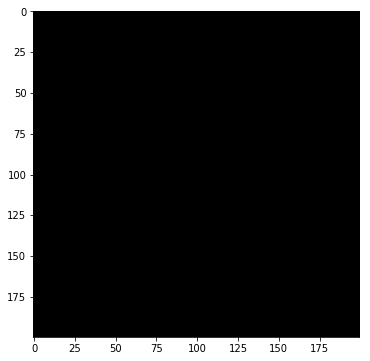

In [91]:
pm = PatchMatch(x,x,y,y, 5)
plt.imshow(pm.visualize())

In [92]:
pm.propagate()
# pm.nnf

[[[0 0]
  [0 0]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]

 ..., 
 [[0 0]
  [0 0]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]]
[[[84 84]
  [84 84]
  [84 84]
  ..., 
  [84 84]
  [84 84]
  [84 84]]

 [[84 84]
  [84 84]
  [84 84]
  ..., 
  [84 84]
  [84 84]
  [84 84]]

 [[84 84]
  [84 84]
  [84 84]
  ..., 
  [84 84]
  [84 84]
  [84 84]]

 ..., 
 [[84 84]
  [84 84]
  [84 84]
  ..., 
  [84 84]
  [84 84]
  [84 84]]

 [[84 84]
  [84 84]
  [84 84]
  ..., 
  [84 84]
  [84 84]
  [84 84]]

 [[84 84]
  [84 84]
  [84 84]
  ..., 
  [84 84]
  [84 84]
  [84 84]]]


In [93]:
np.unique(pm.nnd)

array([ 6.], dtype=float32)

In [88]:
pm.A.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [89]:
pm.nnd.dtype

dtype('float32')